<a href="https://colab.research.google.com/github/MamMates/ml-food-classification/blob/main/MamMates_Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MamMates - Food Classification

Food Classification using CNN

## Prerequisite


https://pypi.org/project/gdown





In [1]:
!pip install gdown -q

## Import neccessary library

In [2]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.regularizers import l2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras import Input, Model
from google.colab import files
import tensorflow as tf
import numpy as np
import tempfile
import zipfile
import shutil
import gdown
import os
%matplotlib inline

In [3]:
np.random.seed(42)

## Download dataset

In [4]:
url = "https://drive.google.com/file/d/1Lh1WKPNpvBi05mRC22fmyE19c85ZeS9-/view?usp=sharing"
gdown.download(url, quiet=True, fuzzy=True)

'dataset.zip'

In [5]:
dataset_path = "dataset.zip"
extract_location = "/dataset"
zip_extractor = zipfile.ZipFile(dataset_path, 'r')
zip_extractor.extractall(extract_location)
zip_extractor.close()

In [6]:
for root, dirs, _ in os.walk(extract_location):
  for i in dirs:
    print(os.path.join(root, i))

/dataset/Dataset Klasifikasi Makanan
/dataset/Dataset Klasifikasi Makanan/Kue Klepon
/dataset/Dataset Klasifikasi Makanan/Donat
/dataset/Dataset Klasifikasi Makanan/Putu Ayu
/dataset/Dataset Klasifikasi Makanan/Kue Lumpur
/dataset/Dataset Klasifikasi Makanan/Kue Lapis
/dataset/Dataset Klasifikasi Makanan/Bika Ambon
/dataset/Dataset Klasifikasi Makanan/Kue Risoles
/dataset/Dataset Klasifikasi Makanan/Kue Cubit
/dataset/Dataset Klasifikasi Makanan/Roti
/dataset/Dataset Klasifikasi Makanan/Dadar Gulung
/dataset/Dataset Klasifikasi Makanan/Kue Klepon/validation
/dataset/Dataset Klasifikasi Makanan/Kue Klepon/test
/dataset/Dataset Klasifikasi Makanan/Kue Klepon/train
/dataset/Dataset Klasifikasi Makanan/Kue Lumpur/validation
/dataset/Dataset Klasifikasi Makanan/Kue Lumpur/test
/dataset/Dataset Klasifikasi Makanan/Kue Lumpur/train
/dataset/Dataset Klasifikasi Makanan/Kue Lapis/validation
/dataset/Dataset Klasifikasi Makanan/Kue Lapis/test
/dataset/Dataset Klasifikasi Makanan/Kue Lapis/train


In [7]:
base_dir = os.path.join(extract_location, 'Dataset Klasifikasi Makanan')
temp = os.listdir(base_dir)
temp, len(temp)

(['Kue Klepon',
  'Donat',
  'Putu Ayu',
  'Kue Lumpur',
  'Kue Lapis',
  'Bika Ambon',
  'Kue Risoles',
  'Kue Cubit',
  'Roti',
  'Dadar Gulung'],
 10)

In [8]:
not_splitted = []
for i in temp:
  curr_path = os.path.join(base_dir, i)
  print(i) if len(os.listdir(curr_path)) == 3 else not_splitted.append(i)

Kue Klepon
Kue Lumpur
Kue Lapis
Kue Risoles
Roti


In [9]:
not_splitted

['Donat', 'Putu Ayu', 'Bika Ambon', 'Kue Cubit', 'Dadar Gulung']

In [10]:
for i in not_splitted:
  if len(os.listdir(os.path.join(base_dir, i))) == 3:
    continue

  base_folder = os.path.join(base_dir, i)
  list_files = [file for file in os.listdir(base_folder)
                  if os.path.isfile(os.path.join(base_folder, file))]

  np.random.shuffle(list_files)

  folders = ['train', 'validation', 'test']
  for f in folders:
    os.makedirs(os.path.join(base_folder, f), exist_ok=True)

  total_files = len(list_files)
  total_train = int(.8 * total_files)
  total_valid = int(.1 * total_files)
  total_test = total_files - total_train - total_valid
  split_counts = [total_train, total_valid, total_test]

  idx = 0
  for f,count in zip(folders, split_counts):
    target_file = list_files[idx:idx+count]
    idx += count

    for i in target_file:
      src = os.path.join(base_folder, i)
      dst = os.path.join(base_folder, f, i)
      shutil.move(src, dst)

In [11]:
folders = ['train', 'validation', 'test']
for f in folders:
  os.makedirs(os.path.join(base_dir, f), exist_ok=True)

for f in os.listdir(base_dir):
  if f not in folders:
    curr_dir = os.path.join(base_dir, f)
    for i in os.listdir(curr_dir):
      fmt_folder = f.lower().replace(' ', '_')
      src = os.path.join(curr_dir, i)
      dst = os.path.join(base_dir, i, fmt_folder)
      shutil.move(src, dst)

In [12]:
test = os.listdir(base_dir)
for i in test:
  curr_dir = os.path.join(base_dir, i)
  total_dir = len(os.listdir(curr_dir))
  os.rmdir(curr_dir) if total_dir == 0 else None

## Data Analysist

In [13]:
os.listdir(os.path.join(base_dir, 'train'))

['kue_risoles',
 'dadar_gulung',
 'donat',
 'kue_cubit',
 'putu_ayu',
 'kue_klepon',
 'kue_lumpur',
 'bika_ambon',
 'roti',
 'kue_lapis']

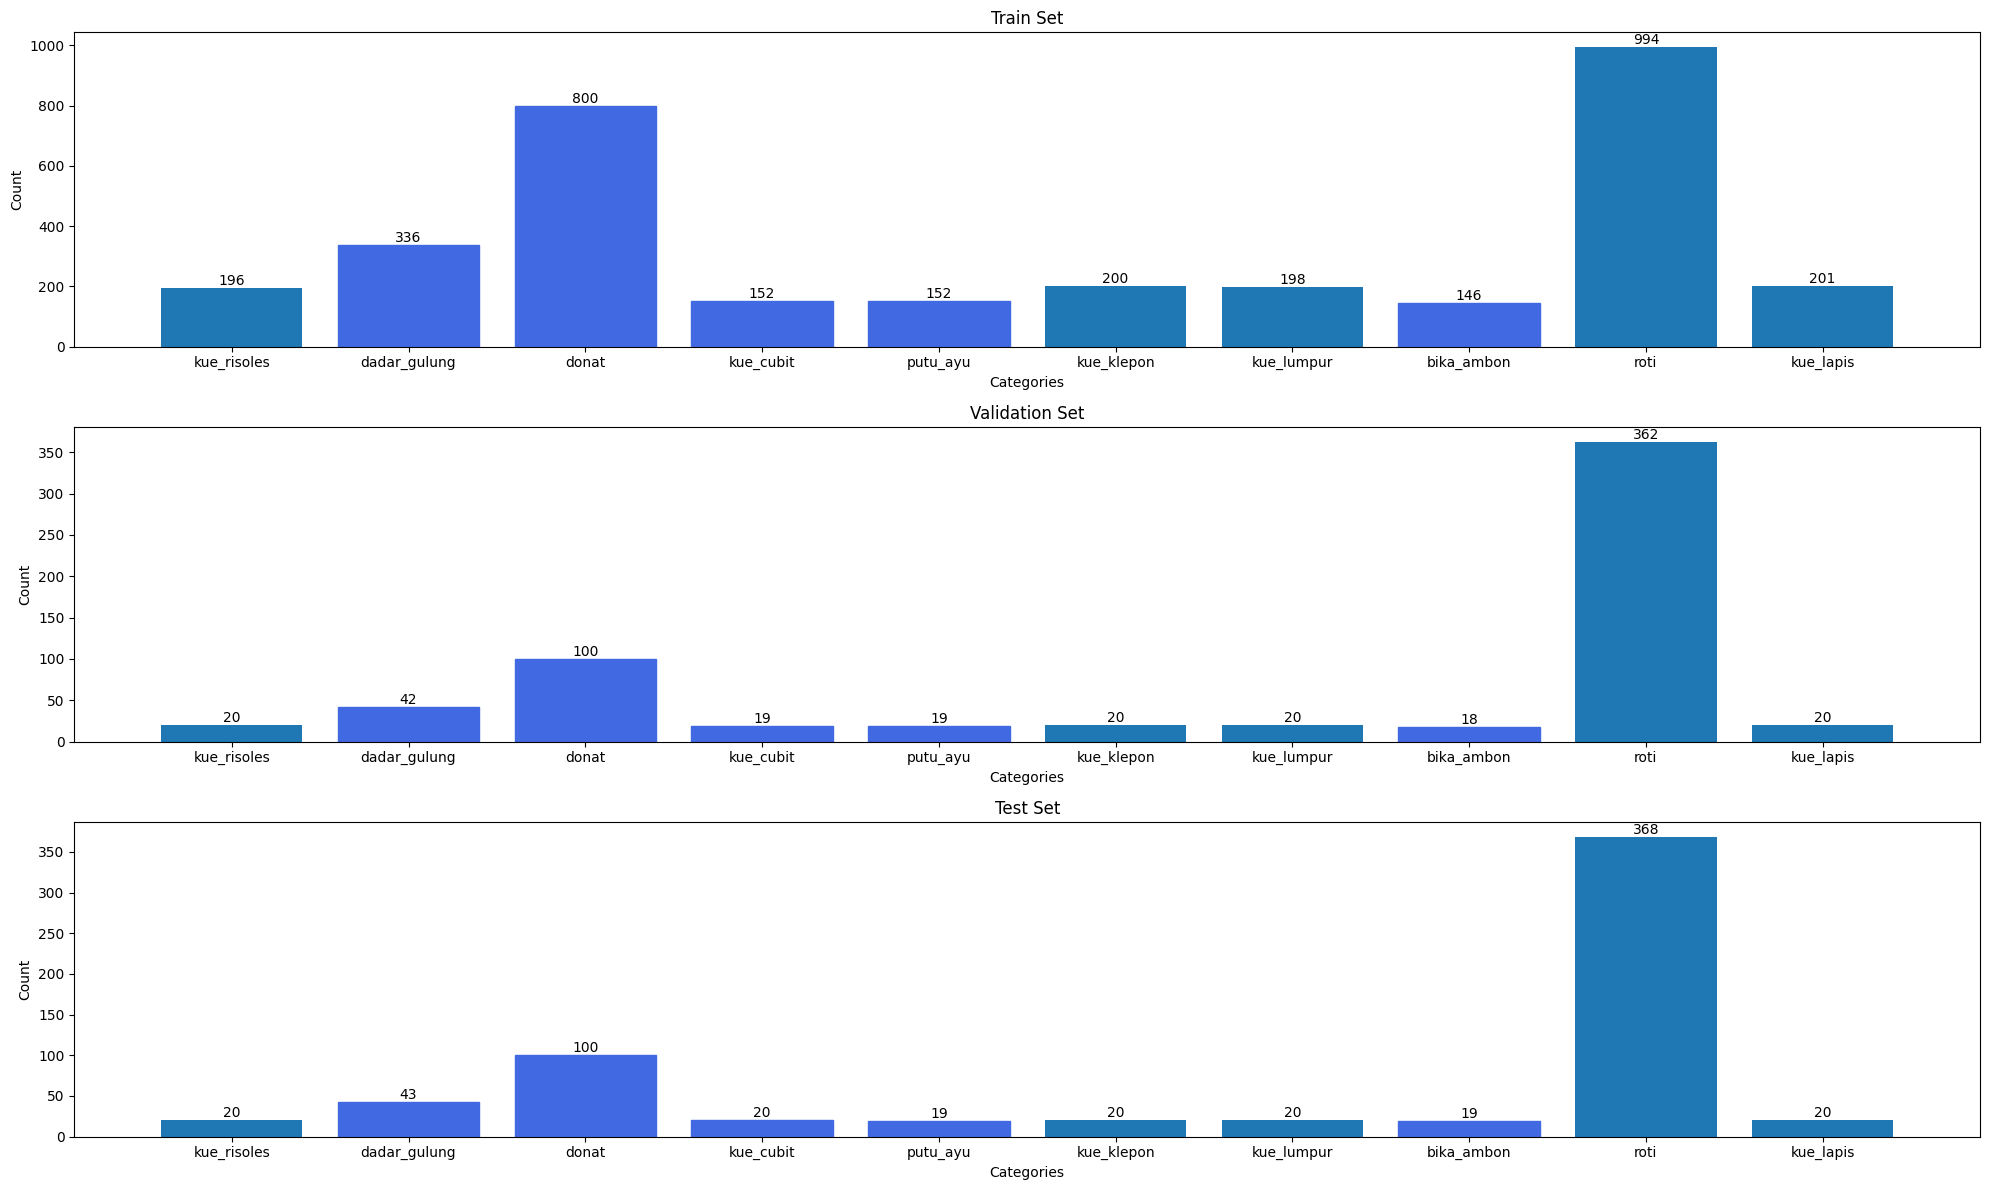

In [14]:
dataset_folder = base_dir
categories = os.listdir(os.path.join(base_dir, 'train'))

data_splits = ['train', 'validation', 'test']

counts = {split: {category: 0 for category in categories} for split in data_splits}

for split in data_splits:
    for category in categories:
        category_folder = os.path.join(dataset_folder, split, category)
        counts[split][category] = len(os.listdir(category_folder))

fig, axes = plt.subplots(3, 1, figsize=(20, 12))

for i, split in enumerate(data_splits):
    ax = axes[i]
    categories_counts = [counts[split][category] for category in categories]
    bars = ax.bar(categories, categories_counts)
    ax.set_title(f'{split.capitalize()} Set')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count')

    for i in not_splitted:
      i = i.lower().replace(" ", "_")
      bars[categories.index(i)].set_color('royalblue')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

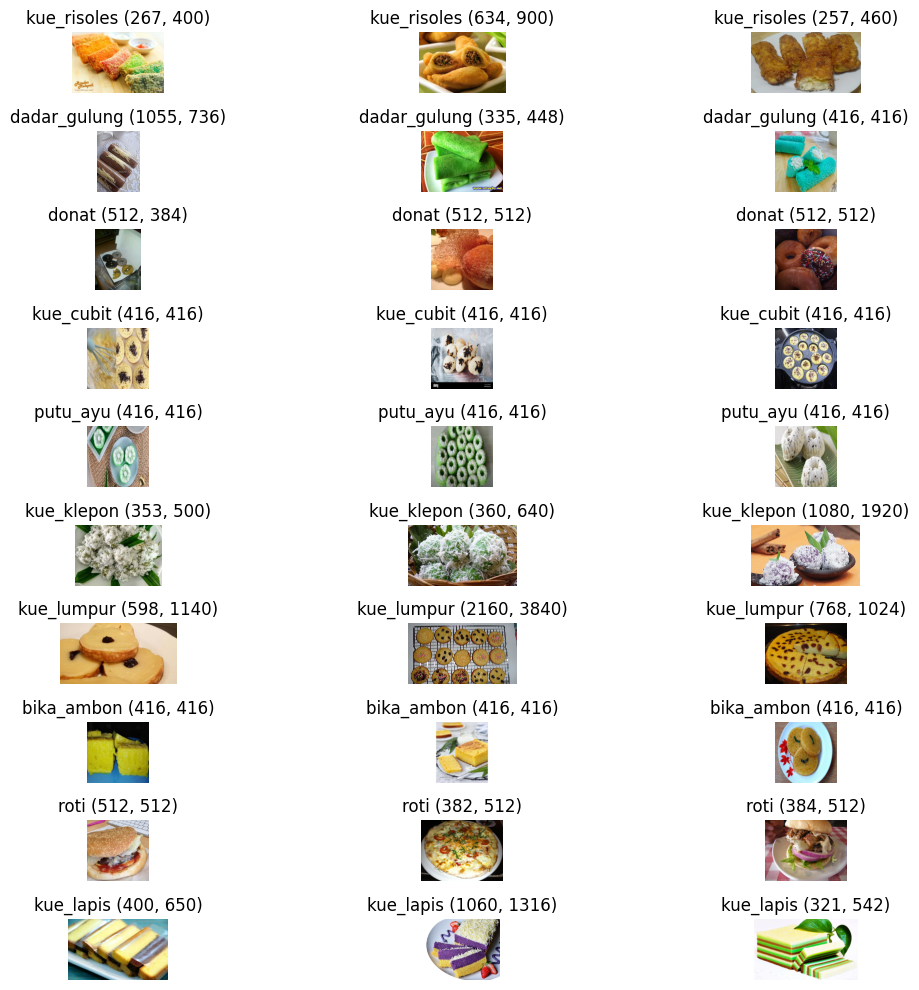

In [15]:
class_count = len(categories)
examples = 3

fig, ax = plt.subplots(class_count, examples, figsize=(12, 10))


for i, category in enumerate(categories):
  category_dir = os.path.join(base_dir, 'train', category)
  image_files = os.listdir(category_dir)

  for j in range(examples):
    rdm = np.random.randint(0, len(image_files))
    img_path = os.path.join(category_dir, image_files[rdm])
    img = mpimg.imread(img_path)
    ax[i, j].imshow(img)
    ax[i, j].set_title(f'{category} {img.shape[:2]}')
    ax[i, j].axis('off')

plt.tight_layout()

plt.show()

## Data Augmentation

In [16]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# REVISION: increse rotation range

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# REVISION: increse target size

validation_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = training_datagen.flow_from_directory(
	train_dir,
 	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
  target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

test_generator = validation_datagen.flow_from_directory(
	test_dir,
  target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

Found 3371 images belonging to 10 classes.
Found 640 images belonging to 10 classes.
Found 649 images belonging to 10 classes.


## Building Model

In [20]:
input_shape = (224, 224, 3)

# REVISION: add regularization L2
# REVISION: add more dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape,
           kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu',
           kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu',
           kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu',
           kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 dropout_5 (Dropout)         (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_6 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                 

In [35]:
# UPDATE: add callback early stopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Model Training

In [36]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data = validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/25
106/106 [==============================] - 57s 519ms/step - loss: 1.5450 - accuracy: 0.4788 - val_loss: 1.3747 - val_accuracy: 0.6266
Epoch 2/25
106/106 [==============================] - 55s 517ms/step - loss: 1.5370 - accuracy: 0.4723 - val_loss: 1.3823 - val_accuracy: 0.6641
Epoch 3/25
106/106 [==============================] - 53s 501ms/step - loss: 1.4734 - accuracy: 0.4978 - val_loss: 1.3060 - val_accuracy: 0.6797
Epoch 4/25
106/106 [==============================] - 54s 511ms/step - loss: 1.4795 - accuracy: 0.5067 - val_loss: 1.4094 - val_accuracy: 0.5344
Epoch 5/25
106/106 [==============================] - 53s 501ms/step - loss: 1.4919 - accuracy: 0.4835 - val_loss: 1.4077 - val_accuracy: 0.6313
Epoch 6/25
106/106 [==============================] - 54s 507ms/step - loss: 1.4762 - accuracy: 0.5022 - val_loss: 1.3728 - val_accuracy: 0.6203
Epoch 6: early stopping


## Model Evaluation

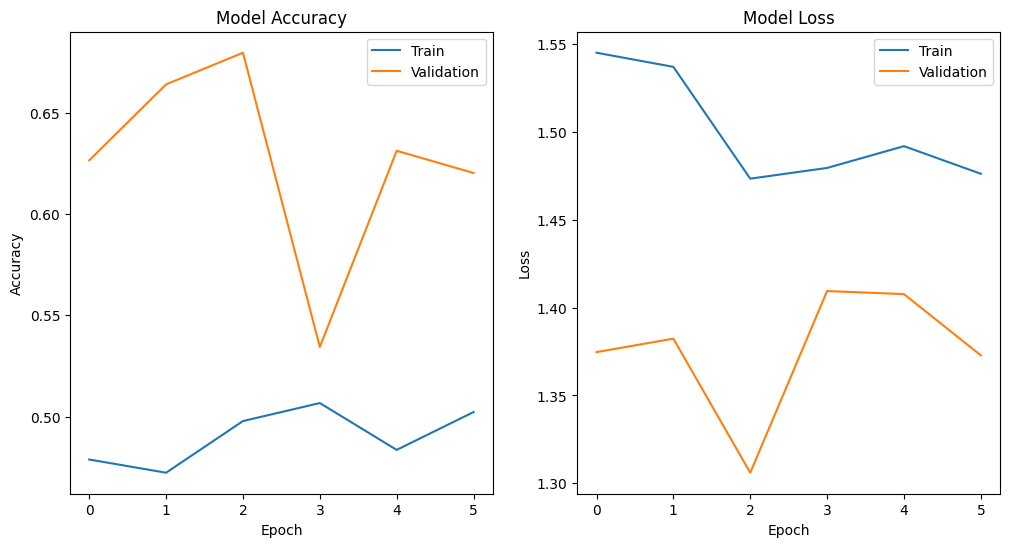

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [38]:
results = model.evaluate(test_generator, batch_size=32)

21/21 [==============================] - 3s 133ms/step - loss: 1.2997 - accuracy: 0.6626


## Transfer Learning

In [39]:
input_shape = (224, 224, 3)

resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

In [40]:
resnet_model.trainable = False

In [41]:
inputs = Input(shape=input_shape)
x = resnet_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation="softmax")(x)
tl_model = Model(inputs=inputs, outputs=outputs)
tl_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [42]:
tl_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [43]:
tl_hist = tl_model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/25
106/106 [==============================] - 60s 529ms/step - loss: 1.1155 - accuracy: 0.6342 - val_loss: 0.4255 - val_accuracy: 0.8766
Epoch 2/25
106/106 [==============================] - 54s 503ms/step - loss: 0.6155 - accuracy: 0.7995 - val_loss: 0.3310 - val_accuracy: 0.9047
Epoch 3/25
106/106 [==============================] - 54s 510ms/step - loss: 0.5023 - accuracy: 0.8360 - val_loss: 0.2887 - val_accuracy: 0.9047
Epoch 4/25
106/106 [==============================] - 56s 531ms/step - loss: 0.4680 - accuracy: 0.8487 - val_loss: 0.2905 - val_accuracy: 0.9094
Epoch 5/25
106/106 [==============================] - 55s 522ms/step - loss: 0.4135 - accuracy: 0.8644 - val_loss: 0.2576 - val_accuracy: 0.9234
Epoch 6/25
106/106 [==============================] - 53s 504ms/step - loss: 0.3994 - accuracy: 0.8707 - val_loss: 0.2817 - val_accuracy: 0.9219
Epoch 7/25
106/106 [==============================] - 55s 517ms/step - loss: 0.3785 - accuracy: 0.8748 - val_loss: 0.2443 - val_ac

## Model Evaluation

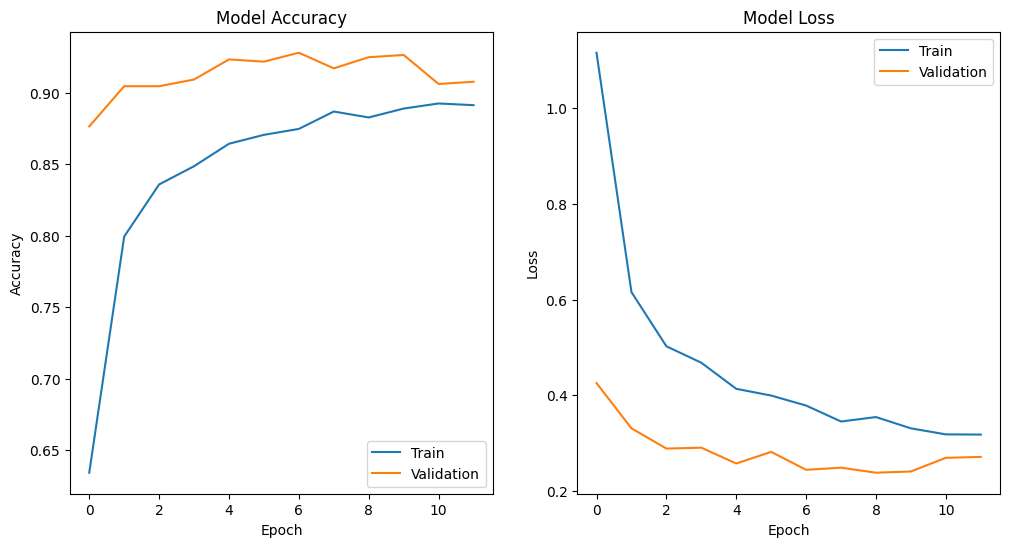

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(tl_hist.history['accuracy'])
plt.plot(tl_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(tl_hist.history['loss'])
plt.plot(tl_hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [45]:
results = tl_model.evaluate(test_generator, batch_size=32)

21/21 [==============================] - 3s 126ms/step - loss: 0.2884 - accuracy: 0.9183


## Save Model

In [46]:
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    tl_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1


Saved model:
total 3352
drwxr-xr-x 2 root root    4096 Dec  4 15:35 assets
-rw-r--r-- 1 root root      57 Dec  4 16:00 fingerprint.pb
-rw-r--r-- 1 root root  604965 Dec  4 16:00 keras_metadata.pb
-rw-r--r-- 1 root root 2811431 Dec  4 16:00 saved_model.pb
drwxr-xr-x 2 root root    4096 Dec  4 16:00 variables


In [47]:
!zip -r model.zip /tmp/1

updating: tmp/1/ (stored 0%)
updating: tmp/1/assets/ (stored 0%)
updating: tmp/1/saved_model.pb (deflated 91%)
updating: tmp/1/fingerprint.pb (stored 0%)
updating: tmp/1/variables/ (stored 0%)
updating: tmp/1/variables/variables.data-00000-of-00001 (deflated 7%)
updating: tmp/1/variables/variables.index (deflated 77%)
updating: tmp/1/keras_metadata.pb (deflated 96%)


## Summary
